# $\S$ 11.6. Example: Simulated Data

We generated data from two additive error models $Y = f(X) + \epsilon$:
* $\text{Sum of sigmoids: } Y = \sigma(a_1^T X) + \sigma(a_2^T X) + \epsilon_1$;
* $\text{Radial: } Y = \prod_{m=1}^{10} \phi(X_m) + \epsilon_2$,

where $X^T = (X_1,X_2,\cdots,X_p) \sim N_p(\mathbf{0}, I)$, with $p=2$ for the first, $p=10$ for the second model.

* For the sigmoid model, $a_1^T = (3, 3)$ and $a_2^T = (3, -3)$;
* for the radial model, $\phi(t) = \frac{1}{\sqrt{2\pi}} \exp(-\frac{t^2}{2})$.
* Both $\epsilon_1$ and $\epsilon_2$ are Gaussian errors, with variance chosen so that the SNR ratio  

  \begin{equation}
  \frac{\text{Var}(\text{E}(Y|X))}{\text{Var}(Y-\text{E}(Y|X))} = \frac{\text{Var}(f(X))}{\text{Var}(\epsilon)}
  \end{equation}

  is 4 in both models.

We took a training sample of size 100 and a test sample of size 10,000.

We fit neural networks with weights decay and various numbers of hidden units, and recorded the average test error

\begin{equation}
\text{E}_{\text{Test}} (Y-\hat{f}(X))^2
\end{equation}

for each of 10 random starting weights.

Only one training set was generated, but the results are typical for an "average" training set.

The test errors are shown in FIGURE 11.6.

In [1]:
%matplotlib notebook
import scipy
import scipy.stats
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import torch

In [2]:
def sigmoid(x:scipy.ndarray)->scipy.ndarray:
    return scipy.reciprocal(1+scipy.exp(-x))


def generate_sigmoid_data(a1:scipy.ndarray,
                          a2:scipy.ndarray,
                          size_train:int,
                          size_test:int)->tuple:
    dim = 2
    train_x = scipy.randn(size_train, dim)
    train_y_true = sigmoid(train_x @ a1) + sigmoid(train_x @ a2)

    test_x = scipy.randn(size_test, dim)
    test_y_true = sigmoid(test_x @ a1) + sigmoid(test_x @ a2)
    test_var = scipy.var(test_y_true)
    epsilon_var = test_var/4
    return (train_x,
            train_y_true,
            train_y_true + scipy.randn(size_train)*scipy.sqrt(epsilon_var),
            test_x,
            test_y_true,
            epsilon_var)


def generate_radial_data(size_train:int, size_test:int)->tuple:
    dim = 10
    train_x = scipy.randn(size_train, dim)
    train_y_true = scipy.stats.norm.pdf(train_x)

    test_x = scipy.randn(size_test, dim)
    test_y_true = scipy.stats.norm.pdf(test_x)
    test_var = scipy.var(test_y_true)
    epsilon_var = test_var/4
    return (train_x,
            train_y_true,
            train_y_true + scipy.randn(size_train)*scipy.sqrt(epsilon_var),
            test_x,
            test_y_true,
            epsilon_var)


def train(model:torch.nn.Module,
          loss_fn:torch.nn.Module,
          optimizer:torch.optim.Optimizer,
          niter:int,
          torch_x:torch.autograd.Variable,
          torch_y:torch.autograd.Variable)->torch.nn.Module:
    for epoch in range(niter):
        y_pred = model(torch_x)

        loss = loss_fn(y_pred, torch_y)

        optimizer.zero_grad()

        loss.backward()

        optimizer.step()
    
    # print(f'{niter} iterations done.')
    # print('loss with weight decay', loss.data[0])
    return loss


def test(model:torch.nn.Module,
         loss_fn:torch.nn.Module,
         torch_x_test:torch.autograd.Variable,
         torch_y_test:torch.autograd.Variable):
    y_pred = model(torch_x_test)
    return loss_fn(y_pred, torch_y_test)

In [3]:
"""FIGURE 11.6. Boxplots of test error, for the sigmoid model

Under construction: currently only the sigmoid model is simulated."""
size_train = 100
size_test = 10000
learning_rate = 1e-4

# Generate training data
train_x, train_y_true, train_y, test_x, test_y, errrate_bayes = (
    generate_sigmoid_data(scipy.array([3, 3]),
                          scipy.array([3, -3]),
                          size_train,
                          size_test)
)

torch_x = torch.autograd.Variable(torch.from_numpy(train_x).float())
torch_y = torch.autograd.Variable(torch.from_numpy(train_y.reshape(100, 1)).float(),
                                  requires_grad=False)

<IPython.core.display.Javascript object>


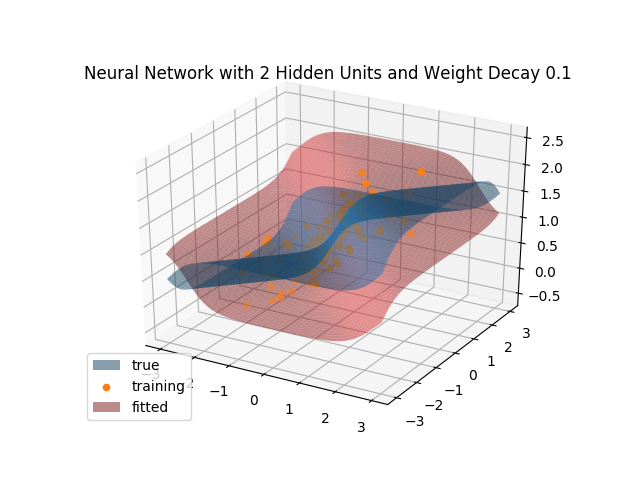

CPU times: user 6.21 s, sys: 902 ms, total: 7.11 s
Wall time: 6.55 s


In [4]:
%%time
# Try only the best model for plot
# We already know which model is the best (as the book said)
niter = 50000
weight_decay = 0.0005

model = torch.nn.Sequential(torch.nn.Linear(2, 2, bias=False),
                            torch.nn.Sigmoid(),
                            torch.nn.Linear(2, 1, bias=False))
optimizer = torch.optim.SGD(model.parameters(),
                            lr=learning_rate,
                            weight_decay=weight_decay)
loss_fn = torch.nn.MSELoss(size_average=False)

# Train that model
loss = train(model, loss_fn, optimizer, niter, torch_x, torch_y)

# Plot
linspace = scipy.linspace(-3, 3, 100)
meshgrid_x, meshgrid_y = scipy.meshgrid(linspace, linspace)
meshgrid_z_true = sigmoid(3*(meshgrid_x+meshgrid_y)) + sigmoid(3*(meshgrid_x-meshgrid_y))

fig1 = plt.figure(1)
ax1 = fig1.add_subplot(1, 1, 1, projection='3d')
surf_true = ax1.plot_surface(meshgrid_x, meshgrid_y, meshgrid_z_true, alpha=.5, label='true')
surf_true._facecolors2d = surf_true._facecolors3d
surf_true._edgecolors2d = surf_true._edgecolors3d
ax1.scatter3D(train_x[:, 0], train_x[:, 1], train_y, color='C1', label='training')

grid_x = scipy.array([[x,y] for x in linspace for y in linspace])
torch_grid_x = torch.autograd.Variable(torch.from_numpy(grid_x).float(),
                                       requires_grad=False)
fitted_grid_z = model(torch_grid_x).data.numpy() #.copy()
fitted_grid_z = fitted_grid_z.reshape(100, 100)
surf_fitted = ax1.plot_surface(meshgrid_x, meshgrid_y, fitted_grid_z,
                               color='C3', alpha=.5, label='fitted')
surf_fitted._facecolors2d = surf_fitted._facecolors3d
surf_fitted._edgecolors2d = surf_fitted._edgecolors3d
ax1.set_title('Neural Network with 2 Hidden Units and Weight Decay 0.1')
ax1.legend(loc='lower left')
plt.show()

In [5]:
# Construct the networks
models_sigmoid = [
    torch.nn.Sequential(
        torch.nn.Linear(2, h, bias=False),
        torch.nn.Sigmoid(),
        torch.nn.Linear(h, 1, bias=False),
    )
    for h in range(1, 11)
]
optimizers = [
    torch.optim.SGD(model.parameters(),
                    lr=learning_rate,
                    weight_decay=weight_decay)
    for model in models_sigmoid
]

In [6]:
%%time
# Try every model for the boxplot
niter = 50000
errors_test = []
for model, optimizer in zip(models_sigmoid, optimizers):
    errors_per_model = []
    for _ in range(10):
        loss_fn = torch.nn.MSELoss(size_average=False)
        train(model, loss_fn, optimizer, niter, torch_x, torch_y)

        torch_x_test = torch.autograd.Variable(torch.from_numpy(test_x).float(),
                                               requires_grad=False)
        torch_y_test = torch.autograd.Variable(torch.from_numpy(test_y).float(),
                                               requires_grad=False)
        test_loss_fn = torch.nn.MSELoss()
        test_loss = test(model, test_loss_fn, torch_x_test, torch_y_test)
        # print(model, test_loss)
        errors_per_model.append(test_loss.data[0])
    errors_test.append(errors_per_model)

CPU times: user 9min 41s, sys: 51.7 s, total: 10min 33s
Wall time: 10min 6s


<IPython.core.display.Javascript object>


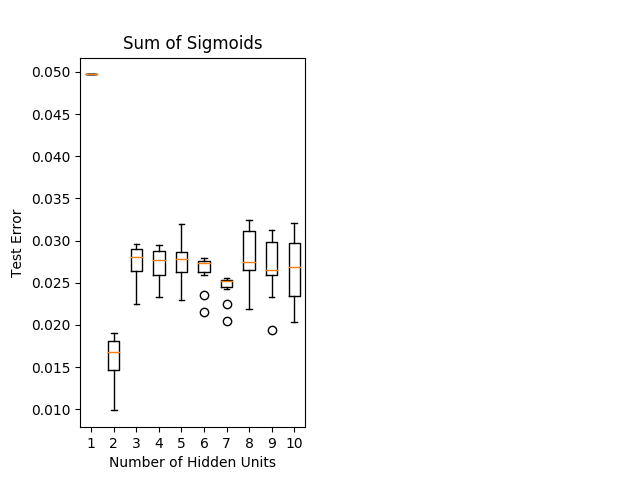

In [7]:
fig2 = plt.figure(2)
ax21 = fig2.add_subplot(1, 2, 1)
ax21.boxplot(errors_test)
ax21.set_xlabel('Number of Hidden Units')
ax21.set_ylabel('Test Error')
ax21.set_title('Sum of Sigmoids')
plt.show()

### Results & interpretation

In this example we used a fixed weights decay parameter of 0.0005, representing a mild amount of regularization. The results in the left panel suggest that more regularization is needed with greater numbers of hidden units.

#### The sigmoids model

Note that the zero hidden unit model refers to linear least squares model. The neural network is perfectly suited to the sum of sigmoids model, and the two-unit model does perform the best, achieving an error close to the Bayes rate (Recall that the Bayes rate for regression with squared error is the error variance; in the figures, we report test error relative to the Bayes error).

Notice, however, that with more hidden units, overfitting quickly creeps in, and with some starting weights the model does worse than the linear model (zero hidden unit) model. Even with two hidden units, two of the ten starting weight configurations produced results no better than the linear model, confirming the importance of multiple starting values.

#### The radial model

> A radial function is in a sense the most difficult for the neural net, as it is spherically symmetric and with no preferred directions.

We see in the right panel that it does poorly in this case, with the test error staying well above the Bayes error. In fact, since a constant fit (such as the sample average) achieves a relative error of 5 (when the SNR is 4), we see that the neural networks perform increasingly worse than the mean.

### Experiment on weight decay

In FIGURE 11.7 we repeated the experiment for the sum of sigmoids model, with no weights decay in the left panel, and stronger weight decay ($\lambda = 0.1$) in the right panel.

With no weight decay, overfitting becomes even more severe for larger numbers of hidden units. The weight decay value $\lambda = 0.1$ produces good results for all numbers of hidden units, and there does not appear to be overfitting as the number of units increases.

In [8]:
"""FIGURE 11.7. Boxplots of test error for the sigmoid model with and without weight decay."""
print('Under construction ...')

Under construction ...


Finally, FIGURE 11.8 shows the test error for a ten hidden unit network, varying the weight decay parameter over a wide range. The value 0.1 is approximately optimal.

In [9]:
"""FIGURE 11.8. Boxplots of test error for 10 hidden units network"""
print('Under construction ...')

Under construction ...


### Practice on selecting free parameters

In summary, there are two free parameters to select:
* The weight decay $\lambda$ and
* the number of hidden units $M$.

As a learning strategy, one could fix either parameter at the value corresponding to the least constrained model, to ensure that the model is rich enough, and use cross-validation to choose the other parameter.

Here the least constrained values are zero weight decay and ten hidden units. Comparing the left panel of FIGURE 11.7 to 11.8, we see that the test error is less sensitive to the value of the weight decay parameter, and hence cross-validation of this parameter would be preferred.